<a href="https://colab.research.google.com/github/nananair/Research-NLP-projects/blob/main/Distributional_analysis_toolkit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook accompanies the article *"Methodological pathways to studying the shareability of news values"*.  

It shows how to perform a quartile-based distributional analysis to explore the shareability of news values.  

The notebook is designed for accessibility: simply upload your labelled dataset (Excel or CSV) in Google Colab, and the analysis will run automatically. No coding experience is required.

⚠️ Make sure your labelled dataset includes a column for each news value, even if some values were not identified in your corpus (e.g., an empty or zero-filled column for "Negativity").  

⚠️ Your dataset must include at least one column with share counts.  
- If you analyse a single platform, name the column **"Share_counts"**.  
- If you analyse multiple platforms, name them **"Share_counts_Twitter"** and/or **"Share_counts_Facebook"**.  
- The code will automatically detect which columns are present and run the analysis separately (and combined, if both are available).  




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


In [9]:
from google.colab import files

print("Please upload your labelled dataset (Excel or CSV).")
uploaded = files.upload()

for filename in uploaded.keys():
    if filename.endswith(".xlsx"):
        df = pd.read_excel(filename)
    elif filename.endswith(".csv"):
        df = pd.read_csv(filename)
    else:
        raise ValueError("File must be .xlsx or .csv")
    break

print("Dataset loaded successfully")
df.head()


Please upload your labelled dataset (Excel or CSV).


Saving updated_thesis_dataset_v2.xlsx to updated_thesis_dataset_v2 (1).xlsx
Dataset loaded successfully


,Articles,Outlet_type,Word_length,Share_counts_Twitter,Share_counts_Facebook,Dataset,Eliteness,Personalisation,Superlativeness,Negativity,Timeliness,Unexpectedness,Impact,Proximity,Positivity,Consonance
0,Second police officer died by suicide followin...,Online-only,247.0,21800,21200,USA,4,0,5,6,1,0,0,8,0,NaN
1,Rioters breached US Capitol security on Wednes...,Popular,622.0,19800,24100,USA,11,4,8,9,10,0,2,11,0,NaN
2,‘They Got a Officer!’: How a Mob Dragged and B...,Quality,441.0,12900,23400,USA,2,0,9,15,0,0,0,9,0,NaN
3,"As the D.C. police clear the Capitol grounds, ...",Quality,468.0,16400,20100,USA,7,0,2,4,7,0,2,13,0,NaN
4,Now it’s sinking in: Wednesday’s Capitol Hill ...,Popular,1042.0,17200,23700,USA,9,9,23,10,8,11,2,11,0,NaN


In [10]:
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Articles               192 non-null    object 
 1   Outlet_type            192 non-null    object 
 2   Word_length            192 non-null    float64
 3   Share_counts_Twitter   192 non-null    int64  
 4   Share_counts_Facebook  192 non-null    int64  
 5   Dataset                192 non-null    object 
 6   Eliteness              192 non-null    int64  
 7   Personalisation        192 non-null    int64  
 8   Superlativeness        192 non-null    int64  
 9   Negativity             192 non-null    int64  
 10  Timeliness             192 non-null    int64  
 11  Unexpectedness         192 non-null    int64  
 12  Impact                 192 non-null    int64  
 13  Proximity              192 non-null    int64  
 14  Positivity             192 non-null    int64  
 15  Conson

,Articles,Outlet_type,Word_length,Share_counts_Twitter,Share_counts_Facebook,Dataset,Eliteness,Personalisation,Superlativeness,Negativity,Timeliness,Unexpectedness,Impact,Proximity,Positivity,Consonance
0,Second police officer died by suicide followin...,Online-only,247.0,21800,21200,USA,4,0,5,6,1,0,0,8,0,NaN
1,Rioters breached US Capitol security on Wednes...,Popular,622.0,19800,24100,USA,11,4,8,9,10,0,2,11,0,NaN
2,‘They Got a Officer!’: How a Mob Dragged and B...,Quality,441.0,12900,23400,USA,2,0,9,15,0,0,0,9,0,NaN
3,"As the D.C. police clear the Capitol grounds, ...",Quality,468.0,16400,20100,USA,7,0,2,4,7,0,2,13,0,NaN
4,Now it’s sinking in: Wednesday’s Capitol Hill ...,Popular,1042.0,17200,23700,USA,9,9,23,10,8,11,2,11,0,NaN


Available share count columns: ['Share_counts_Twitter', 'Share_counts_Facebook', 'Share_counts_Total']

--- Quartile Analysis for Share_counts_Twitter ---


/tmp/ipython-input-773948248.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_scores = df.groupby("Share_Quartile")[news_values].mean().reset_index()


,Share_Quartile,Negativity,Positivity,Impact,Personalisation,Eliteness,Superlativeness,Consonance,Unexpectedness,Proximity,Timeliness
0,Q1,4.122807,0.649123,4.561404,0.719298,9.666667,2.403509,NaN,0.0000,7.736842,2.473684
1,Q2,4.341463,0.414634,2.951220,0.487805,8.073171,1.707317,NaN,0.0000,7.000000,2.902439
2,Q3,4.369565,0.260870,1.369565,0.586957,7.413043,0.869565,NaN,0.0000,6.913043,3.239130
3,Q4,9.500000,0.395833,4.000000,4.000000,17.333333,6.270833,NaN,0.8125,13.229167,5.041667


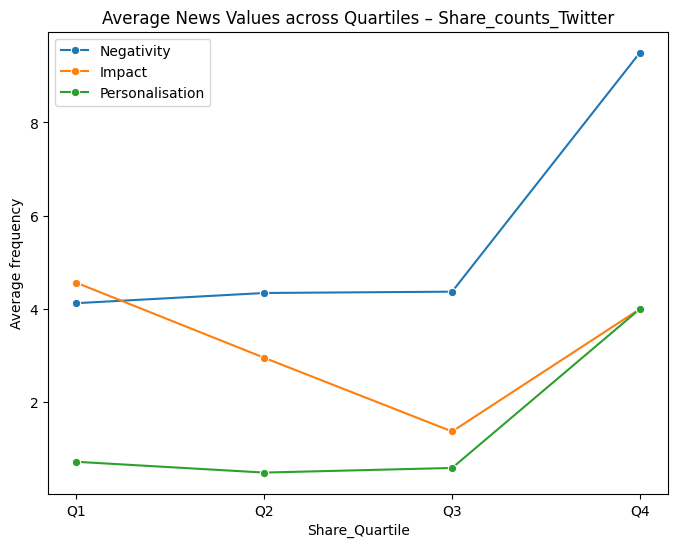


--- Quartile Analysis for Share_counts_Facebook ---


/tmp/ipython-input-773948248.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_scores = df.groupby("Share_Quartile")[news_values].mean().reset_index()


,Share_Quartile,Negativity,Positivity,Impact,Personalisation,Eliteness,Superlativeness,Consonance,Unexpectedness,Proximity,Timeliness
0,Q1,4.440678,0.338983,2.898305,0.610169,8.898305,1.491525,NaN,0.000000,7.542373,2.881356
1,Q2,3.538462,0.358974,2.487179,0.461538,7.666667,1.435897,NaN,0.000000,6.871795,2.717949
2,Q3,4.659574,0.531915,3.957447,0.617021,8.063830,2.361702,NaN,0.000000,8.106383,2.659574
3,Q4,9.595745,0.553191,3.872340,4.191489,18.127660,6.234043,NaN,0.829787,12.489362,5.319149


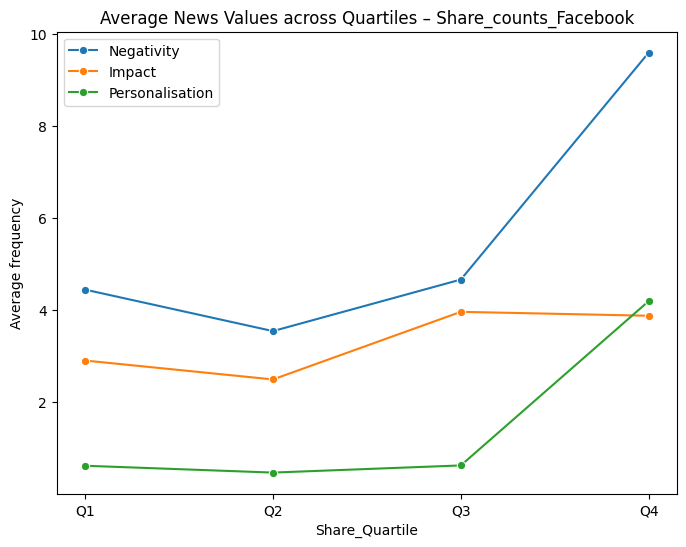


--- Quartile Analysis for Share_counts_Total ---


/tmp/ipython-input-773948248.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_scores = df.groupby("Share_Quartile")[news_values].mean().reset_index()


,Share_Quartile,Negativity,Positivity,Impact,Personalisation,Eliteness,Superlativeness,Consonance,Unexpectedness,Proximity,Timeliness
0,Q1,4.150943,0.490566,3.962264,0.452830,9.150943,1.924528,NaN,0.000000,7.566038,2.811321
1,Q2,3.888889,0.422222,3.022222,0.666667,8.200000,1.533333,NaN,0.000000,7.355556,2.777778
2,Q3,4.446809,0.319149,2.212766,0.808511,7.446809,1.574468,NaN,0.000000,6.893617,2.723404
3,Q4,9.914894,0.531915,3.957447,4.000000,18.106383,6.446809,NaN,0.829787,13.297872,5.297872


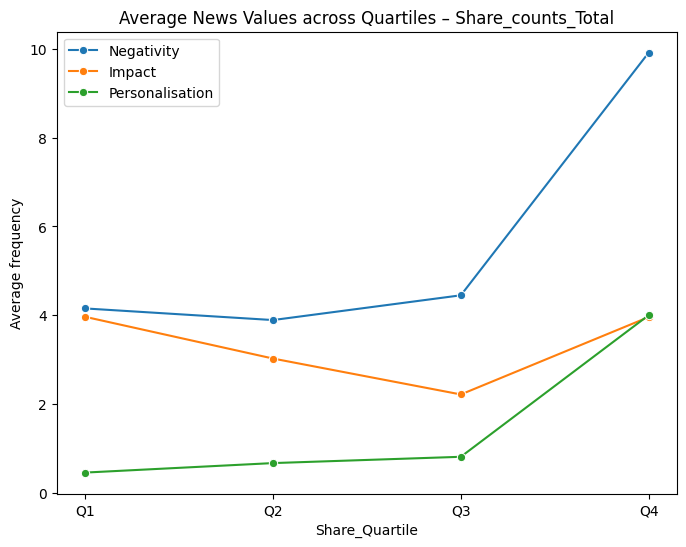


--- Quartile Analysis for Combined Shares ---


/tmp/ipython-input-773948248.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_scores = df.groupby("Share_Quartile")[news_values].mean().reset_index()


,Share_Quartile,Negativity,Positivity,Impact,Personalisation,Eliteness,Superlativeness,Consonance,Unexpectedness,Proximity,Timeliness
0,Q1,4.150943,0.490566,3.962264,0.452830,9.150943,1.924528,NaN,0.000000,7.566038,2.811321
1,Q2,3.888889,0.422222,3.022222,0.666667,8.200000,1.533333,NaN,0.000000,7.355556,2.777778
2,Q3,4.446809,0.319149,2.212766,0.808511,7.446809,1.574468,NaN,0.000000,6.893617,2.723404
3,Q4,9.914894,0.531915,3.957447,4.000000,18.106383,6.446809,NaN,0.829787,13.297872,5.297872


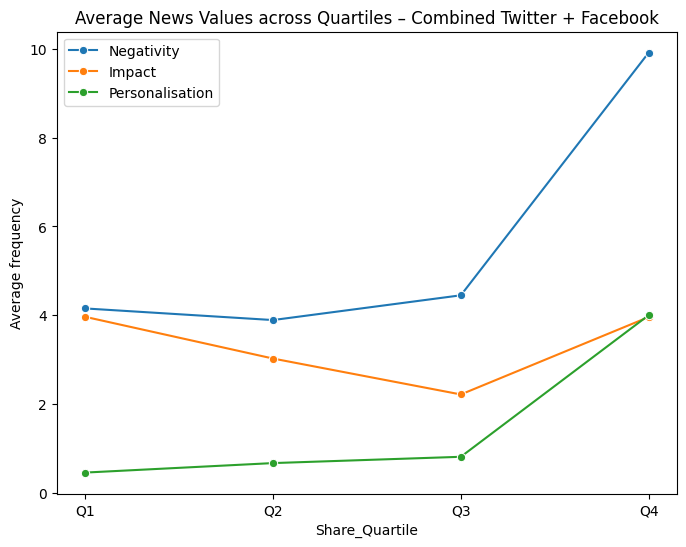

✅ Results exported to 'quartile_analysis_results.xlsx'


In [12]:
news_values = [
    "Negativity",
    "Positivity",
    "Impact",
    "Personalisation",
    "Eliteness",
    "Superlativeness",
    "Consonance",
    "Unexpectedness",
    "Proximity",
    "Timeliness"
]

available_share_cols = [col for col in df.columns if "Share_counts" in col]

print("Available share count columns:", available_share_cols)

results_tables = {}

# CASE 1: If both Twitter & Facebook available (separate analysis)
for col in available_share_cols:
    print(f"\n--- Quartile Analysis for {col} ---")

    df["Share_Quartile"] = pd.qcut(df[col], q=4, labels=["Q1", "Q2", "Q3", "Q4"])
    avg_scores = df.groupby("Share_Quartile")[news_values].mean().reset_index()

    display(avg_scores)

    results_tables[col] = avg_scores

    plt.figure(figsize=(8,6))
    for nv in ["Negativity", "Impact", "Personalisation"]:
        sns.lineplot(data=avg_scores, x="Share_Quartile", y=nv, marker="o", label=nv)

    plt.title(f"Average News Values across Quartiles – {col}")
    plt.ylabel("Average frequency")
    plt.legend()
    plt.show()

# CASE 2: If platforms combined (total shares)
if len(available_share_cols) > 1:
    df["Share_counts_Total"] = df[available_share_cols].sum(axis=1)
    print("\n--- Quartile Analysis for Combined Shares ---")

    df["Share_Quartile"] = pd.qcut(df["Share_counts_Total"], q=4, labels=["Q1", "Q2", "Q3", "Q4"])
    avg_scores = df.groupby("Share_Quartile")[news_values].mean().reset_index()

    display(avg_scores)

    results_tables["Combined"] = avg_scores

    plt.figure(figsize=(8,6))
    for nv in ["Negativity", "Impact", "Personalisation"]:
        sns.lineplot(data=avg_scores, x="Share_Quartile", y=nv, marker="o", label=nv)

    plt.title("Average News Values across Quartiles – Combined Twitter + Facebook")
    plt.ylabel("Average frequency")
    plt.legend()
    plt.show()


In [13]:
df.to_excel("shareworthiness_results.xlsx", index=False)
files.download("shareworthiness_results.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Done!  

You have successfully run a shareworthiness analysis on your dataset.  
This notebook is fully reproducible and can be adapted to any dataset annotated with news values.  

